# Principal Component Analysis



In [1]:
import numpy as np

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scienceplots
from celluloid import Camera

from IPython.display import Image

np.random.seed(0)
plt.style.use(["science", "no-latex"])

Text(0.5, 0.92, 'Data')

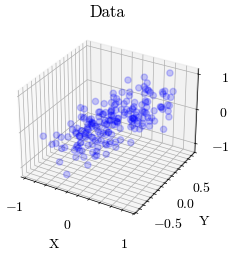

In [2]:
def generate_noisy_hyperplane(num_points, start_pt, end_pt, noise=0.25):
    # create a plane from the start to the end point
    t = np.linspace(0.0 + noise, 1.0 - noise, num_points).reshape(-1, 1)
    points = start_pt + t * (end_pt - start_pt)

    # add noise to plane
    noise = np.random.normal(0, noise, size=(num_points, 3))
    points = points + noise

    return points


start_pt = np.array([-1, -1, -1])
end_pt = np.array([1, 1, 1])
X = generate_noisy_hyperplane(200, start_pt, end_pt)

# plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.2, color="blue", label="Original Data")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Data")

## Variance and Eigendecomposition of Covariance Matrix

variance

In [3]:
def pca(X, dims):
    # subtract the mean to center the data
    X_centered = X - np.mean(X, axis=0)

    # compute covariance matrix
    cov = np.cov(X_centered.T)

    # eigendecomposition of the covariance matrix
    # the eigenvectors are the principal components
    # the principal components are the columns of the eig_vecs matrix
    eig_vals, eig_vecs = np.linalg.eig(cov)

    # sort the eigenvalues and eigenvectors
    sorted_idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[sorted_idx]
    eig_vecs = eig_vecs[:, sorted_idx]

    # perform dimensionality reduction using the computed principal components
    # if you want to reduce to K dimensions, simplify take the first K columns
    projected = X_centered @ eig_vecs

    # compute the variance of each dimension (column)
    pc_variances = [np.var(projected[:, i]) for i in range(dims)]

    return eig_vals, eig_vecs, projected, pc_variances

In [4]:
def create_plots():
    fig = plt.figure(figsize=(16 / 9.0 * 4, 4 * 1))
    fig.suptitle("Principal Component Analysis")

    ax0 = fig.add_subplot(121, projection="3d")
    ax0.set_xlabel("X")
    ax0.set_ylabel("Y")
    ax0.set_zlabel("Z")
    ax0.set_title("PC Hyperplanes")
    ax0.view_init(17, -125, 2)
    ax0.set_xlim(-1, 1)
    ax0.set_ylim(-1, 1)
    ax0.set_zlim(-1, 1)
    ax0.tick_params(axis="both", which="both", length=0)

    ax1 = fig.add_subplot(122, projection="3d")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.set_title("Projected Data")
    ax1.view_init(17, -125, 2)
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    ax1.tick_params(axis="both", which="both", length=0)
    # plt.axis('equal')

    camera = Camera(fig)
    return ax0, ax1, camera


def plot_hyperplane(ax, pc_vector, color="red", scaling=10, alpha=0.3):
    # Create a grid of points
    points = np.linspace(-1, 1, scaling)
    xx, yy = np.meshgrid(points, points)

    # the z value is the defined by the hyperplane from the principal component vector
    pc_vector /= np.linalg.norm(pc_vector)
    z = (-pc_vector[0] * xx - pc_vector[1] * yy) / pc_vector[2]

    ax.plot_surface(xx, yy, z, color=color, alpha=alpha)

In [5]:
def visualize_pca(X, dims, output_filename):
    ax0, ax1, camera = create_plots()
    colors = ["red", "green", "blue"]

    for dim in range(0, dims + 1):
        eig_vals, eig_vecs, projected, pc_variances = pca(X, dims)

        # plot the original data
        ax0.scatter(X[:, 0], X[:, 1], X[:, 2], color="blue", label="Original Data")

        # plot the pca hyperplanes
        for i in range(dim):
            plot_hyperplane(ax0, eig_vecs[:, i], color=colors[i])

        # plot the projected data from the principal components
        curr_projected = projected
        for i in range(dim, dims):
            if i < dims:
                curr_projected[:, i] = 0
        if dim != 0:
            ax1.scatter(
                curr_projected[:, 0],
                curr_projected[:, 1],
                curr_projected[:, 2],
                color="blue",
                label="Projected Data",
            )

        camera.snap()

    animation = camera.animate(interval=2000)
    animation.save(output_filename, writer="pillow")
    plt.show()

    eig_vals, eig_vecs, projected, pc_variances = pca(X, dims)

    print("variance percentage per principal component")
    variance_percentage = eig_vals / np.sum(eig_vals)
    for i, percentage in enumerate(variance_percentage):
        print(f"{i+1}th PC: {round(percentage*100, 2)}%")

    print("variance per principal component")
    for i, variance in enumerate(pc_variances):
        print(f"{i+1}th PC: {round(variance, 2)}")

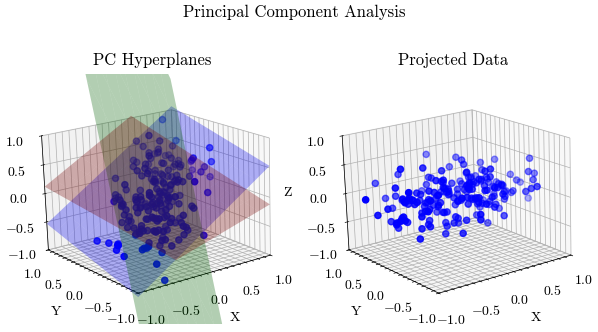

variance percentage per principal component
1th PC: 69.38%
2th PC: 16.8%
3th PC: 13.82%
variance per principal component
1th PC: 0.28
2th PC: 0.07
3th PC: 0.06


In [6]:
dims = 3
output_filename = "pca.gif"

visualize_pca(X, dims, output_filename)

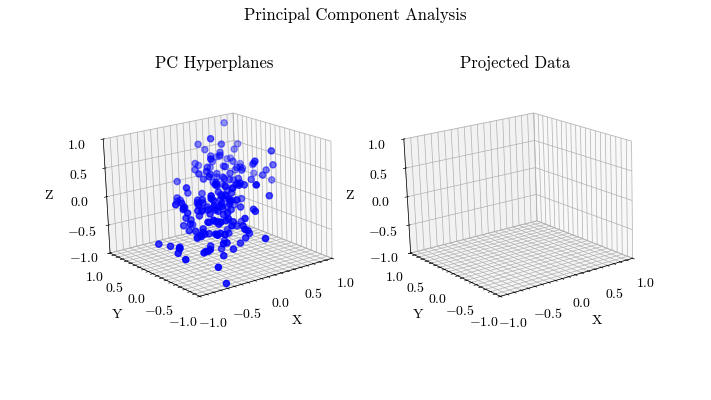

In [7]:
Image(filename=output_filename)